In [63]:
import numpy as np
from PIL import Image
import torch

import torch
from PIL import Image

def generate_binary_masks(image):
    # Convert PIL image to PyTorch tensor
    image_tensor = torch.tensor(np.array(image))
    
    # Get unique values in the image tensor
    unique_values = torch.unique(image_tensor)
    
    # Initialize an empty tensor to store binary masks
    masks = torch.zeros(len(unique_values), image_tensor.shape[0], image_tensor.shape[1], dtype=torch.uint8)
    
    # For each unique value, generate a binary mask
    for id_mask, value in enumerate(unique_values):
        masks[id_mask,:,:] = torch.where(image_tensor == value, 1, 0)
    
    return masks

# Test the function
image = Image.open('data/idd20k_lite/train/0/024541_label.png')
binary_images = generate_binary_masks(image)

# Now, binary_images is a list of binary images
binary_images.shape

torch.Size([7, 227, 320])

In [4]:
import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)


7
[0 6]


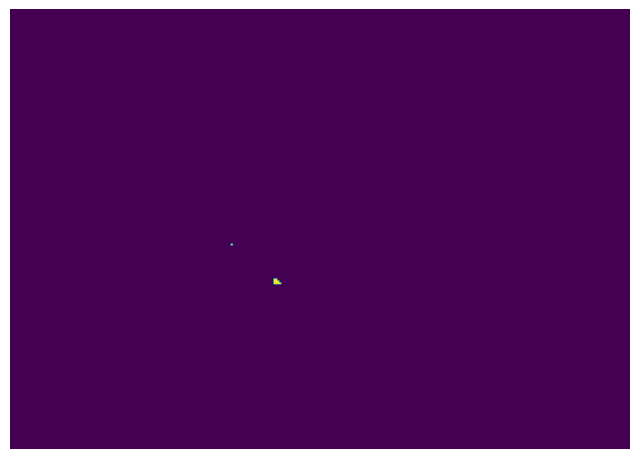

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_masks(masks):
    # Get the number of masks and their dimensions
    num_masks, height, width = masks.shape
    
    # Create a new figure
    plt.figure(figsize=(8, 8))
    mask_final = np.zeros((height,width))

    # Color palette from Seaborn, as a total of 8 elements
    #color_palette = sns.diverging_palette(10,210,8,center="dark")
    #my_cmap = ListedColormap(color_palette.as_hex())
    
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#fd0000","#ffff00"]
    my_cmap = ListedColormap(sns.color_palette(flatui))

    print(num_masks)
    # Plot each mask with a random color
    for i in range(0,num_masks):
        mask_final = np.where((masks[i, :, :] == 1), i, 0)

        
    plt.imshow(mask_final)
    print(np.unique(mask_final))
    # Show the plot
    plt.axis('off')
    plt.show()

plot_masks(binary_images)

In [62]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#fd0000","#ffff00"]
my_cmap = ListedColormap(sns.color_palette(flatui))
binary_images[1,:,:]


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

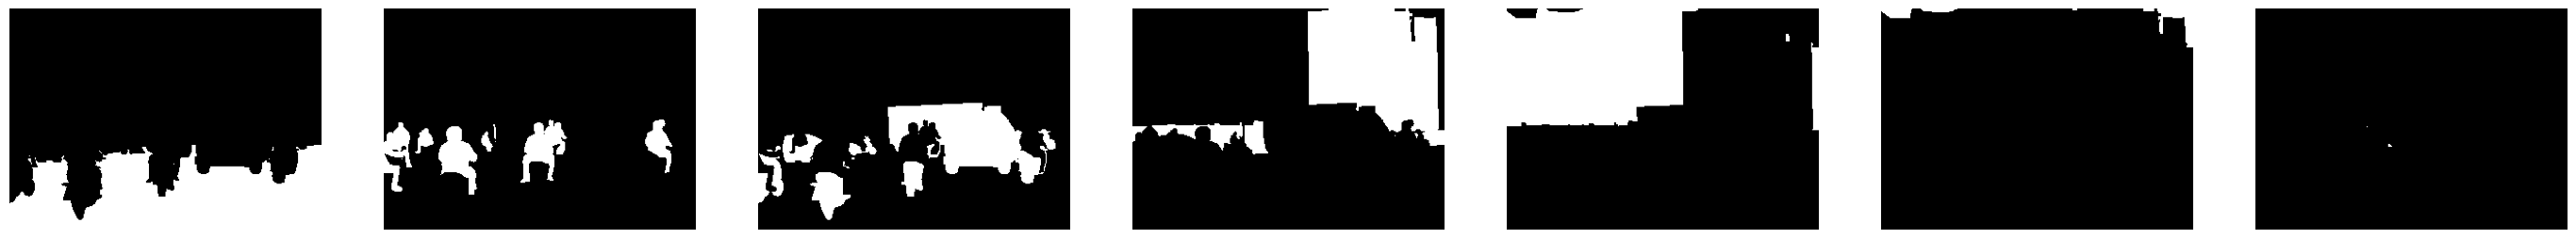

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_masks(tensor):
    # Ensure tensor is a numpy array
    if not isinstance(tensor, np.ndarray):
        tensor = tensor.numpy()

    # Get the number of masks
    num_masks = tensor.shape[0]

    # Create subplots
    fig, axs = plt.subplots(1, num_masks, figsize=(num_masks*5, 5))

    # If there's only one mask, axs won't be an array, so we convert it into an array
    if num_masks == 1:
        axs = np.array([axs])

    # Plot each mask
    for i in range(num_masks):
        axs[i].imshow(tensor[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

plot_masks(binary_images)

(3, 227, 320)
(7, 227, 320)
(0.0, 0.16666666666666666, 1.0)
(227, 320, 3)


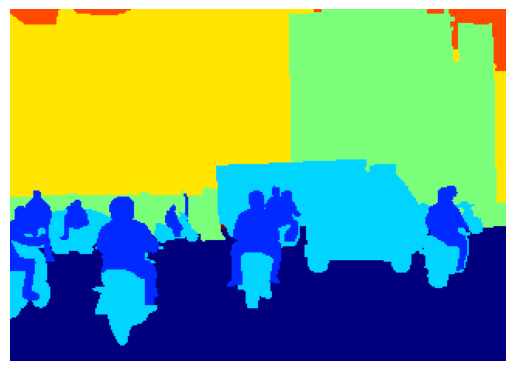

In [103]:
def plot_combined_masks(tensor):
    # Ensure tensor is a numpy array
    if not isinstance(tensor, np.ndarray):
        tensor = tensor.numpy()

    # Get the number of masks
    num_masks = tensor.shape[0]

    # Create a color map with num_masks colors
    cmap = plt.get_cmap('jet', num_masks)

    # Create an empty image
    combined_image = np.zeros((3, tensor.shape[1], tensor.shape[2]))
    print(combined_image.shape)
    print(tensor.shape)
    print(cmap(1)[:3])
    output = np.zeros((3, tensor.shape[1], tensor.shape[2]))
    # Add each mask to the image with a different color

    # Create an empty output array
    output = np.zeros((3, tensor.shape[1], tensor.shape[2]))

    # For each mask
    for i in range(num_masks):
        # Apply the color map to the mask and add it to the output
        for j in range(3):
            output[j,:,:] = tensor[i,:,:] * cmap(i)[j]
        combined_image += output



    # Clip the values to be between 0 and 1
    #combined_image = np.clip(combined_image, 0, 1)

    # Plot the combined image
    combined_image = combined_image.transpose(1,2,0)
    print(combined_image.shape)
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()


plot_combined_masks(binary_images)